In [2]:
import sys
sys.path.append('../src')

import numpy as np
import scipy.io
import pandas as pd
from scipy.spatial.distance import cdist

# Load data
X = scipy.io.loadmat('../data/data_train.mat')['data_train']
y = scipy.io.loadmat('../data/label_train.mat')['label_train'].flatten()
X_test = scipy.io.loadmat('../data/data_test.mat')['data_test']

print(f"Training data: {X.shape}")
print(f"Test data:     {X_test.shape}")

# From Phase 4 and 5 (copy your actual values)
final_selected = [79, 129, 201, 62, 115, 192, 89, 291, 300]
sigma_refined = np.array([3.19214981, 5.32172426, 7.2600029, 3.9186115, 
                          11.20612224, 4.73982264, 6.09735277, 4.36944061, 3.49549728])
W = np.array([0.31843685, 1.64511092, 3.32111063, 2.38670609, 
              -3.59455555, -3.74609518, 1.39322291, 0.38423756, 0.69952924])

final_H = len(final_selected)



Training data: (301, 33)
Test data:     (50, 33)


In [4]:

N_test = X_test.shape[0]  # 50
Phi_test = np.zeros((N_test, final_H))

print("\nComputing RBF features for test data...")

for j in range(final_H):
    center_j = X[final_selected[j]]  # Training sample as center
    sigma_j = sigma_refined[j]
    
    # Compute distances from all test samples to this center
    distances = np.linalg.norm(X_test - center_j, axis=1)  # (50,)
    
    # Apply Gaussian RBF
    Phi_test[:, j] = np.exp(- distances**2 / (2 * sigma_j**2))

print(f"  Φ_test shape: {Phi_test.shape}")



Computing RBF features for test data...
  Φ_test shape: (50, 9)


In [5]:
# Apply output weights
y_test_pred_raw = Phi_test @ W
y_test_pred = np.sign(y_test_pred_raw)

# Handle zeros (assign to +1)
y_test_pred[y_test_pred == 0] = 1


print("PREDICTIONS:")
print(f"Class +1: {np.sum(y_test_pred ==  1)} samples")
print(f"Class -1: {np.sum(y_test_pred == -1)} samples")


PREDICTIONS:
Class +1: 33 samples
Class -1: 17 samples


In [18]:
# Create DataFrame with results
results = pd.DataFrame({
    'Sample_ID': range(1, N_test + 1),
    'Raw_Output': y_test_pred_raw,
    'Predicted_Class': y_test_pred.astype(int)
})
confidence = np.minimum(np.abs(y_test_pred_raw), 1.0) * 100
results['Confidence'] = confidence

print("\nFirst 10 predictions:")
print(results.head(10))

# Save to Excel
output_path = '../data/test_predictions.csv'
results.to_csv(output_path, index=False)




First 10 predictions:
   Sample_ID  Raw_Output  Predicted_Class  Confidence
0          1   -0.266155               -1   26.615473
1          2    0.577515                1   57.751492
2          3   -0.064446               -1    6.444647
3          4   -1.053095               -1  100.000000
4          5    0.833667                1   83.366688
5          6    0.726599                1   72.659875
6          7   -1.373703               -1  100.000000
7          8    0.432451                1   43.245091
8          9    0.096630                1    9.663027
9         10   -0.844366               -1   84.436597


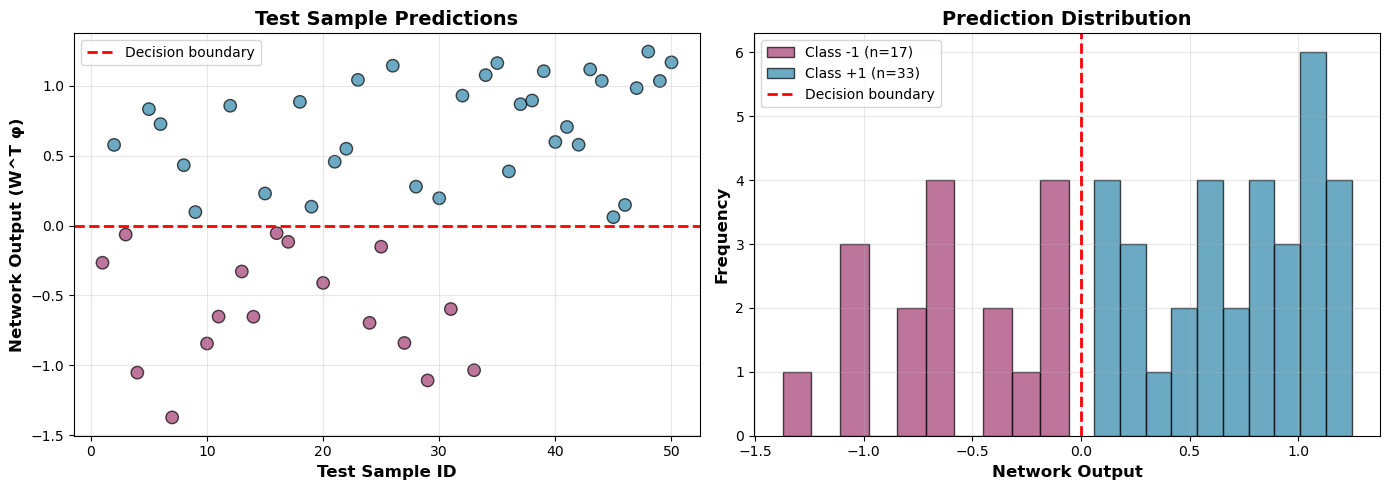

In [9]:
import matplotlib.pyplot as plt
import os
os.makedirs('../plots', exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Raw outputs
colors = ['#A23B72' if pred == -1 else '#2E86AB' for pred in y_test_pred]
axes[0].scatter(range(1, N_test + 1), y_test_pred_raw,
               c=colors, s=80, alpha=0.7, edgecolors='black', linewidth=1)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2, 
                label='Decision boundary')
axes[0].set_xlabel('Test Sample ID', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Network Output (W^T φ)', fontsize=12, fontweight='bold')
axes[0].set_title('Test Sample Predictions', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].legend(fontsize=10)

# Plot 2: Prediction distribution
bins_neg = y_test_pred_raw[y_test_pred == -1]
bins_pos = y_test_pred_raw[y_test_pred ==  1]

axes[1].hist(bins_neg, bins=10, alpha=0.7, color='#A23B72', 
            label=f'Class -1 (n={len(bins_neg)})', edgecolor='black')
axes[1].hist(bins_pos, bins=10, alpha=0.7, color='#2E86AB',
            label=f'Class +1 (n={len(bins_pos)})', edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2,
               label='Decision boundary')
axes[1].set_xlabel('Network Output', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Prediction Distribution', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../plots/test_predictions.png', dpi=300, bbox_inches='tight')
plt.show()


In [20]:
# Categorize by confidence
high_conf = results[results['Confidence'] > 85]
med_conf = results[(results['Confidence'] >= 40) & (results['Confidence'] <= 85)]
low_conf = results[results['Confidence'] < 40]

print("\n" + "=" * 60)
print("PREDICTION CONFIDENCE BREAKDOWN")
print("=" * 60)
print(f"High confidence (|output| > 1.0): {len(high_conf)} samples")
print(f"  Class +1: {np.sum(high_conf['Predicted_Class'] ==  1)}")
print(f"  Class -1: {np.sum(high_conf['Predicted_Class'] == -1)}")
print()
print(f"Medium confidence (0.3 ≤ |output| ≤ 1.0): {len(med_conf)} samples")
print(f"  Class +1: {np.sum(med_conf['Predicted_Class'] ==  1)}")
print(f"  Class -1: {np.sum(med_conf['Predicted_Class'] == -1)}")
print()
print(f"Low confidence (|output| < 0.3): {len(low_conf)} samples")
print(f"  Class +1: {np.sum(low_conf['Predicted_Class'] ==  1)}")
print(f"  Class -1: {np.sum(low_conf['Predicted_Class'] == -1)}")
print("=" * 60)

if len(low_conf) > 0:
    print("\nLow confidence predictions:")
    print(low_conf[['Sample_ID', 'Raw_Output', 'Predicted_Class', 'Confidence']])


PREDICTION CONFIDENCE BREAKDOWN
High confidence (|output| > 1.0): 20 samples
  Class +1: 16
  Class -1: 4

Medium confidence (0.3 ≤ |output| ≤ 1.0): 16 samples
  Class +1: 9
  Class -1: 7

Low confidence (|output| < 0.3): 14 samples
  Class +1: 8
  Class -1: 6

Low confidence predictions:
    Sample_ID  Raw_Output  Predicted_Class  Confidence
0           1   -0.266155               -1   26.615473
2           3   -0.064446               -1    6.444647
8           9    0.096630                1    9.663027
12         13   -0.328655               -1   32.865473
14         15    0.229530                1   22.952984
15         16   -0.054479               -1    5.447885
16         17   -0.116496               -1   11.649623
18         19    0.135259                1   13.525936
24         25   -0.151376               -1   15.137559
27         28    0.278510                1   27.850970
29         30    0.195887                1   19.588700
35         36    0.387862                1   38.7